# Regressão linear para maximizar o crescimento da banca de estratégia de apostas com Pytorch

Nesse notebook irei demonostrar como aplicar, a partir de vários inputs, a regressão para definir quando e quanto apostar afim de maximar o crescimento da banca de apostas (bankroll),que é isso que queremos, ter o máximo de dinheiro no menor tempo possível.

Um modelo linear é o mais simples que podemos criar, entretanto para definição estratégia de apostas ainda não encontrei um modelo mais eficiente. O Pytorch permite criar modelos mais complexos expandindo o modelo linear aqui proposto.

A classe [linear_model.LinearRegression](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html) é forma mais simples e popular de fazer uma regressão linear em Python, mas aqui vamos utilizar o Pytorch, pois esse último permite com facilidade a definção de uma **Função Custo Personalizada (Custom Loss Function)**

Nesse exemplo, nosso dataset possui os inputs rolutados  de "A" a "P", os quais podem ser quaisquer estatísiticas do esporte que podem inlufuenciar no desfecho da apostas como:


**Para o futebol:**
* gols;
* chutes, 
* escanteios 
* minutos sem tomar gols


**Para o tênis:**
* aces;
* duplas faltas;
* quebras de serviço;


**Para o beisebol:**
* home runs;
* rebatidas;


Sejam somas ou médias das estatísticas de uma dado período de tempo. A determinação de qual estatística ou qual intervalo temporal é mais relevante para a definição da estratégia é um processo de tentativa e erro. Normalmente quanto mais melhor, mas há casos no quais menos variávies deixa o modelo mais eficiente.


### PL
PL é a variável dependente, é o que vamos modelar, é o Y do modelo onde os inputs são os Xs.

A sigla PL pode ser Profit-Loss ou Perda-Lucro, tanto em português quanto em inglês faz sentido. PL é o retorno líquido da aposta, quanto ganhamos ou perdemos em dada aposta resolvida. Numa aposta de odds 1.95, se ganhamos -> <span style="color:green">PL=0.95</span>,  se perdemos -> <span style="color:red">PL=-1.00</span>

Veja abaixo está nosso dataset.

In [1]:
import numpy as np  
import pandas as pd 

df=pd.read_csv('/kaggle/input/exemplo-regresso-apostas/under.csv')
df

,A,B,C,D,E,F,G,H,I,J,K,L,M,N,O,P,PL
0,0,2,55,16,0,2,5,4,0,1.75,1.800,2.000,0,0,0,1,-0.50
1,2,4,28,11,0,0,6,5,0,1.50,1.900,1.900,0,0,1,0,-1.00
2,3,9,52,6,1,5,2,0,0,1.25,1.975,1.825,0,1,0,0,-1.00
3,1,8,34,9,1,8,0,3,0,1.50,1.750,2.050,0,0,1,0,-1.00
4,0,2,66,6,0,2,10,4,0,1.25,1.950,1.850,0,1,0,0,-1.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
355368,0,7,80,8,0,3,10,4,0,1.75,1.775,2.025,0,0,0,1,-0.50
355369,0,3,60,11,0,1,6,3,0,2.00,1.900,1.900,1,0,0,0,-1.00
355370,2,4,51,8,2,0,11,4,0,1.50,1.950,1.850,0,0,1,0,0.95
355371,2,3,39,16,0,3,9,0,0,1.50,1.900,1.950,0,0,1,0,0.90


Como é natural, por se tratar de apostas, na média as casas de aposta levam vantagem sobre os apostadores. Se apostarmos sem qualquer critério, na média, teremos prejuízo mensurado pela média do PL. 

In [2]:
print('PL médio:',round(df.PL.mean()*100,2), '%')

PL médio: -2.28 %


Logo, se apostarmos sem qualquer critério nosso prejuízo será de 2.28% por aposta, mas através da regressão podemo selecionar apenas as apostas que nos fornecerão PL médio positivo.

É desejável, mas não indispensável, que os inputs estejam transformados em escala de ** 0 a 1**. Testei com e sem, e a transformação a melhorou eficácia e lucratividade do modelo. Portanto, abaixo vamos selecionar as colunas dos inputs e transforma-las.

In [3]:
from sklearn.preprocessing import MinMaxScaler

#Essa construção faz sentido se você for reprimir alguma coluna de input
colunas='A,B,C,D,E,F,G,H,I,J,K,L,M,N,O,P'.split(',')
df=df[colunas+['PL']] 

#Defina defini a escala a partir dos dados e faz a trasnformação dos inputs, mas não do PL
escala=MinMaxScaler().fit(df[colunas])
df[colunas]=escala.transform(df[colunas])

df

,A,B,C,D,E,F,G,H,I,J,K,L,M,N,O,P,PL
0,0.000,0.071429,0.179402,0.205128,0.000000,0.117647,0.037313,0.060606,0.0,0.272727,0.164491,0.216710,0.0,0.0,0.0,1.0,-0.50
1,0.250,0.142857,0.089701,0.141026,0.000000,0.000000,0.044776,0.075758,0.0,0.227273,0.190601,0.190601,0.0,0.0,1.0,0.0,-1.00
2,0.375,0.321429,0.169435,0.076923,0.142857,0.294118,0.014925,0.000000,0.0,0.181818,0.210183,0.171018,0.0,1.0,0.0,0.0,-1.00
3,0.125,0.285714,0.109635,0.115385,0.142857,0.470588,0.000000,0.045455,0.0,0.227273,0.151436,0.229765,0.0,0.0,1.0,0.0,-1.00
4,0.000,0.071429,0.215947,0.076923,0.000000,0.117647,0.074627,0.060606,0.0,0.181818,0.203655,0.177546,0.0,1.0,0.0,0.0,-1.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
355368,0.000,0.250000,0.262458,0.102564,0.000000,0.176471,0.074627,0.060606,0.0,0.272727,0.157963,0.223238,0.0,0.0,0.0,1.0,-0.50
355369,0.000,0.107143,0.196013,0.141026,0.000000,0.058824,0.044776,0.045455,0.0,0.318182,0.190601,0.190601,1.0,0.0,0.0,0.0,-1.00
355370,0.250,0.142857,0.166113,0.102564,0.285714,0.000000,0.082090,0.060606,0.0,0.227273,0.203655,0.177546,0.0,0.0,1.0,0.0,0.95
355371,0.250,0.107143,0.126246,0.205128,0.000000,0.176471,0.067164,0.000000,0.0,0.227273,0.190601,0.203655,0.0,0.0,1.0,0.0,0.90


A seguir a divisão do nosso dataframe entre 80% treinamento e 20% teste

In [4]:
df_train=df[:int(len(df)*0.8)]
df_test=df[-int(len(df)*0.2):]

print('df_train:', len(df_train), 'rows')
print('df_test :', len(df_test), 'rows')

df_train: 284298 rows
df_test : 71074 rows


Importamos a biblioteca do Pytroch e criamos dois [Tensors](https://pytorch.org/docs/stable/tensors.html), um para o PL e outro para os INPUTs do dataframe de treinamento.

In [5]:
import torch

INPUTS=torch.from_numpy(df_train[colunas].values).float()
PL=torch.from_numpy(df_train[['PL']].values).float()

print('INPUTS: ',INPUTS)
print('PL: ',PL)

INPUTS:  tensor([[0.0000, 0.0714, 0.1794,  ..., 0.0000, 0.0000, 1.0000],
        [0.2500, 0.1429, 0.0897,  ..., 0.0000, 1.0000, 0.0000],
        [0.3750, 0.3214, 0.1694,  ..., 1.0000, 0.0000, 0.0000],
        ...,
        [0.1250, 0.2857, 0.1229,  ..., 0.0000, 1.0000, 0.0000],
        [0.0000, 0.0357, 0.2625,  ..., 1.0000, 0.0000, 0.0000],
        [0.2500, 0.2500, 0.1296,  ..., 1.0000, 0.0000, 0.0000]])
PL:  tensor([[-0.5000],
        [-1.0000],
        [-1.0000],
        ...,
        [-1.0000],
        [ 0.4375],
        [-1.0000]])


A seguir, a definição do modelo linear com tantas entradas quantos campos de inputs e 1 saída.

In [6]:
MODELO=torch.nn.Linear(INPUTS.shape[1], 1)

MODELO

Linear(in_features=16, out_features=1, bias=True)

Vamos treinar nosso MODELO para prever o PL médio da aposta baseado nos inputs. 

Para tanto, será utilizado, como função custo, a [MSELoss](https://pytorch.org/docs/stable/nn.html#mseloss) que a fim de reduzir o quadrado da diferença entre PL_pred (previsto) e o PL (real). (PL_pred-PL)<sup>2</sup>

O algoritmo de otimização será o [Adam](https://pytorch.org/docs/stable/optim.html#algorithms) (que se mostrou superior a outros testados), com taxa de aprendizado 0.1 ( a faixa mais se mostrou eficiente foi em 0.01 e 1.0 ) 

In [7]:
loss_func = torch.nn.MSELoss()
otimizador = torch.optim.Adam(MODELO.parameters(), lr = 0.1) 
print('Função Custo:',loss_func)
print('Otimizador:',otimizador)

Função Custo: MSELoss()
Otimizador: Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    eps: 1e-08
    lr: 0.1
    weight_decay: 0
)


Vamos para otimização propriamente dita. Criamos um loop for e para cada passada, mais reduzimos nossa função custo e por conseguinte, mais o PL_pred estará próximo do PL real.

O número de passadas (epochs) vai depender da quantidade de inputs e taxa de aprendizado, acompanhamos decaimento da função custo para escolher quando parar.

In [8]:
loss_list=[]
for _ in range(100):
    PL_pred=MODELO( INPUTS )        #calcula  PL_pred usando o modelo 
    loss=loss_func(PL_pred, PL)     #calcula o erro médio da estimativa do PL_pred 
    
    otimizador.zero_grad() #limpa gradientes antigos
    loss.backward()       #calcula a derivada do loss, através do retropropação
    otimizador.step()     #faz com que o otimizador dê um passo com base nos gradientes dos parâmetros. 
    
    loss_list+=[loss.item()] #acumula o valor para análise

Plotando evolução da função custo vemos que com 100 passadas já não apresenta substancial melhoria.

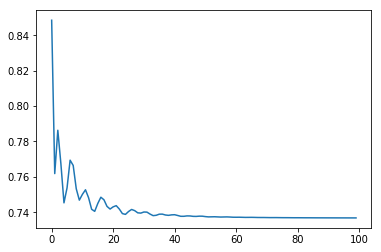

In [9]:
import matplotlib.pyplot as plt

plt.plot(loss_list)
plt.show()

Caso nosso modelo linear esteja bem treinado e com capactidade preditiva, a média do PL das apostas cujo o PL_pred é positivo também será positivo. Ou seja,caso apostarmos apenas em apostas cujo PL_pred>0 teremo lucro a longo prazo.

Vamos verificar lucratividade da estratégia no dataframe de teste.

In [10]:
INPUTS_test=torch.from_numpy(df_test[colunas].values).float()  #Transforma em tensor o inputs de testes
PL_pred=MODELO(INPUTS_test).detach().numpy()  #Calcula os PL previstos para cada input de testes

#Calcula a média do PL reais das apostas cujo o PL previsto é positivo, ou seja lucrativas.
PL_medio_test=np.mean([pl for pl_pred,pl in zip(PL_pred, df_test.PL.values ) if pl_pred[0]>0])

print('PL_medio_test:',round(PL_medio_test*100,2),'%')

PL_medio_test: 3.07 %


Se tivessemos seguido o critério de só apostar quando o PL_pred>0 teríamos o lucro acima contra o prejuízo de -2.28% por aposta sem qualquer critério. 😃

É de se esperar que, quanto maior for o critério de corte para apostar maior será a lucratividade média também. 

Abaixo está plotado no eixo X os cortes e o no Y o PL médio.

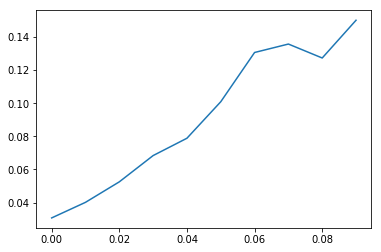

In [11]:
cortes=[i*0.01 for i in range(10)]
pl_medios=[np.mean([pl for pl_pred,pl in zip(PL_pred, df_test.PL.values ) if pl_pred[0]>i*0.01]) for i in range(10) ]

plt.plot(cortes, pl_medios)
plt.show()

## Maximização do Crescimento da Banca

Acima definimos um critério de quando apostar, mas quanto apostar em cada seleção ? Podemos investir um valor fixo cada aposta, mas nossa banca crescerá linearmente. Se investirmos um percentual da banca em cada aposta nossa banca crescerá de forma exponencial.

Vamos através da regressão definir o percentual da banca ótimo a fim de maximizar o crescimento.


Contiuamos com o mesmo modelo linear, mas vamos treiná-lo usando uma função de custo personalizada. 

In [12]:
#Otimiza para maximizar o crescimento da banca    
def loss_somalog(P_pred,PL):
    return -torch.log(1+PL*P_pred.relu()).sum()

loss_somalog

<function __main__.loss_somalog(P_pred, PL)>

**P_pred** é percentual ótimo da banca previsto a fim de maximar o crecimento da banca

Se **P_pred<0** então **P_pred.relu()** será 0, ou seja, nada será apostado

PL é pl ocorrido da aposta

O sinal negativo se faz necessário, pois, por padrão,o otimizador procura minimizar a função custo ao passo que, necessitamos maximizar o soma do log do crescimento da banca.



O otimizador será igual o anterior, mas com taxa de aprendizagem bem menor 

In [13]:
#Mesmo otimizador, mas com taxa de aprendizagem menor
otimizador = torch.optim.Adam(MODELO.parameters(), lr = 0.001) 

otimizador

Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    eps: 1e-08
    lr: 0.001
    weight_decay: 0
)

Vamos para otimização, como a taxa de aprendizado é menor será necessário mais passadas.

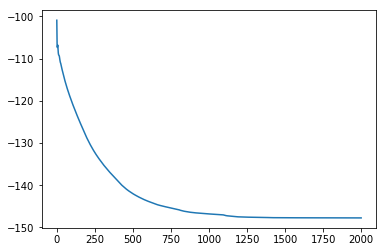

In [14]:
loss_list=[]
for _ in range(2000):
    P_pred=MODELO( INPUTS )         #P_pred (percentual ótimo da banca ) usando o modelo 
    loss=loss_somalog(P_pred, PL)     #loss (quanto menor maior o lucro) dado P_pred 
    
    otimizador.zero_grad() #limpa gradientes antigos
    loss.backward()       #calcula a derivada do loss, através do retropropação
    otimizador.step()     #faz com que o otimizador dê um passo com base nos gradientes dos parâmetros. 
    
    loss_list+=[loss.item()] #acumula o valor para análise
    

#Plota o gráfico da evolução do loss
plt.plot(loss_list)
plt.show()

O valor  da função custo próximo a -150, como a cima, significa se fossem realizadas todas apostas com o percentual ótimo da banca calculado pelo MODELO, no conjunto de treinamento, teríamos na teoria, nossa banca multiplicada por exp(150) 

exp(150)=139370958066638000000000000000000000000000000000000000000000000000 😱

Vamos agora testar a lucratividade dos dados de treinamento, que o que importa

In [15]:
P_pred=MODELO(INPUTS_test).detach().numpy()

somalog=sum(np.log(1+pl*p_pred ) for p_pred,pl in zip(P_pred, df_test.PL.values) if p_pred>0)

print('Log do Crescimento da Banca do Cojunto de Teste:', somalog )

Log do Crescimento da Banca do Cojunto de Teste: [32.835896]


Na teoria também, se tivessemos realizadas todas as apostas com o percentual ótimo definido pelo MODELO com nossos dados de teste, teríamos nossa banca multiplicada por exp(32), quase 79 trilhões (coisa pouca né).

O valor absoluto da somalog não importa tanto, mas sim, a evolução desse número dada a melhoria no modelo.


Por fim, vamos ver a equação do modelo linear, que será como usaremos na prática.

In [16]:
parms=[parm.data.numpy() for parm in MODELO.parameters()][0][0]
inter=[parm.data.numpy() for parm in MODELO.parameters()][1][0]

print('PERCENT_BANCA=')
for p,c in zip(parms/(escala.data_max_-escala.data_min_), colunas):
    print(round(p,5),'*',c,'+')
    
print(round(sum(-parms*escala.data_min_/(escala.data_max_-escala.data_min_))+inter,5))

PERCENT_BANCA=
-0.00958 * A +
-0.00971 * B +
-0.00061 * C +
-0.00878 * D +
-0.06208 * E +
-0.00266 * F +
-0.0011 * G +
-0.00285 * H +
0.01239 * I +
0.17904 * J +
0.03263 * K +
-0.13409 * L +
0.00795 * M +
0.01584 * N +
-0.00075 * O +
-0.01164 * P +
0.1196


Essa equação já está com a transformação inversa de escala, pronta para ser usada.

Conhecidos os parametros de "A" a "P", teremos o percentual ótimo da banca para apostar.